In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as sp
from PIL import Image
import math
import scipy.stats
Q_MATRIX = np.array([[8,8,6,6,4,4,2,2],
                       [8,8,6,6,4,4,2,2],
                       [6,6,6,6,4,4,2,2],
                       [6,6,6,6,4,4,2,2],
                       [4,4,4,4,4,4,2,2],
                       [4,4,4,4,4,4,2,2],
                       [2,2,2,2,2,2,2,2],
                       [2,2,2,2,2,2,2,2]],np.int32)

In [3]:
def snr(f,g):
    f = np.asanyarray(f, dtype="float")
    g = np.asanyarray(g, dtype="float")
    var = np.sum(np.square(f))
    rss = np.sum(np.square(f-g))
    return np.where(var == 0, float("inf"), 10*np.log10(var/rss))

In [4]:
def psnr(a,oa):
    a = np.asanyarray(a, dtype="float")
    mse = np.square(oa-a).mean()
    return np.where(mse == 0, 0, 10*np.log10(255*255/mse))

In [5]:
def mse(og,new):
    return np.square(og-new).mean()

In [6]:
def dct_wave(N, w):
    wave = np.zeros(N, dtype='float')
    
    if (w==0):
        norm_factor = np.sqrt(1/N)
    else:
        norm_factor = np.sqrt(2/N)
    for i in range(N):   
        wave[i] = norm_factor * np.cos( w * (np.pi * (2*i + 1))/(2*N) )
        
    return wave

In [7]:
def dct_wave_2d(N, u, v):
    
    wave_x = dct_wave(N, u)
    wave_y = dct_wave(N, v)
    
    return np.outer(wave_x, wave_y)

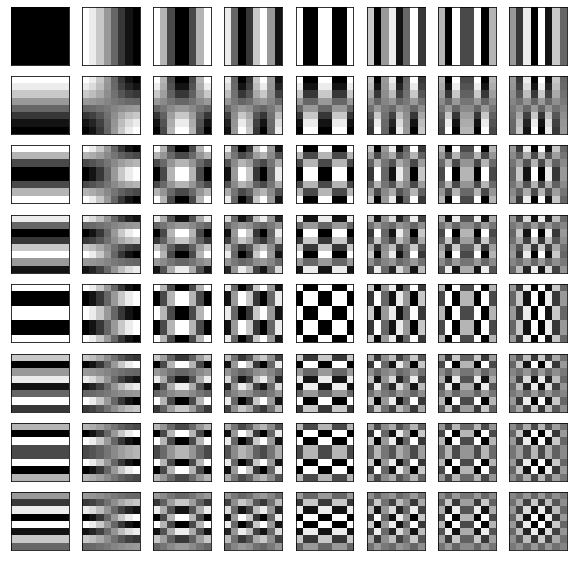

In [8]:
n = 8

fig = plt.figure(figsize=(10,10))
i = 0
for u in range(n):
    for v in range(n):
        
        plt.subplot(n,n,i+1)
        plt.imshow(dct_wave_2d(n, u, v), norm=None, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        i += 1

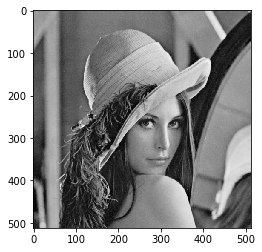

(512, 512)


In [9]:
data_dir = r"C:\Users\callu\Pictures\Test\\"
#data_dir = r"./coursework-data/"
img = Image.open(data_dir+"lena.png").convert("L")
img = np.asarray(img)
plt.imshow(img, cmap="gray")
plt.show()
print(img.shape)

In [10]:
def DCT_inv(coeffs, dct_basis, N):
    recon = np.zeros((N,N))
    for k in range(N):
        for l in range(N):
            recon+=coeffs[k,l]*dct_basis[k,l]
    return recon

In [11]:
def makeBasis(inp):
    inp=inp
    
    dct_basis = np.zeros((inp, inp, inp, inp)) 

    for k in range(inp):
        for l in range(inp):
            dct_basis[k, l] = dct_wave_2d(inp,k,l)
    
    return dct_basis

In [12]:
def dctBlock(im, dct_basis, N):
    coeffs = np.zeros((N,N))
    for k in range(N):
        for l in range(N):
            coefficient = np.dot(im.flatten(), dct_basis[k,l].flatten()) # dot product x.b
            coeffs[k,l] = coefficient
    return coeffs

In [13]:
def bdctTransform(image, bs, t=0, q=False):
    base = makeBasis(bs)
    dctim = np.zeros((image.shape))
    for i in range(0,image.shape[0],bs):
        for j in range(0,image.shape[1],bs):
            im = image[i:i+bs,j:j+bs]
            dctres = dctBlock(im,base,bs)
            if t<=0:
                None
            else:
                dctres = blockThresh(dctres, t)
            if q == True:
                dctres = qBlock(dctres)
            dctim[i:i+bs,j:j+bs] = dctres
    return dctim

In [14]:
def bidctTransform(dctim, bs):
    base = makeBasis(bs)
    recim = np.zeros((dctim.shape))
    for i in range(0,dctim.shape[0],bs):
        for j in range(0,dctim.shape[1],bs):
            im = dctim[i:i+bs,j:j+bs]
            recres = DCT_inv(im,base,bs)
            recim[i:i+bs,j:j+bs] = recres
    return recim

In [169]:
def blockThresh(block, thresh):
    bign = 0
    bigs = 0
    for r in block:
        for c in r:
            if abs(c)>bigs:
                if abs(c)>bign:
                    bigs=bign
                    bign=abs(c)
                    continue
                bigs=abs(c)
    for x in range(block.shape[0]):
        for y in range(block.shape[0]):
            if abs(block[x,y])<thresh*bign:
                block[x,y] = 0
    return block

In [227]:
def getThreshes(img):
    threshes = [0.01,0.02,0.03,0.05,0.1,0.15,0.2,0.3,0.4,0.5]
    threshd = []
    pthreshd = []
    for i in range(0,10):
        thresh = threshes[i]
        pthreshd.append(bdctTransform(img,8,thresh))
        threshd.append(bidctTransform(pthreshd[i],8))
    return threshd, pthreshd

In [228]:
def findCompPix(block):
    bs = block.shape[0]
    for x in range(bs-1,-1,-1):
        for y in range(bs-1,-1,-1):
            if block[x,y] != 0:
                if (x+y)<=bs-1:
                    return np.square(bs)-triNum(x+y+1)
                return triNum((bs+1)-(x+y)-1)
    return bs*bs

def triNum(n):
    num = int(n*(n+1)/2)
    return num

def findCompRatio(im, bs):
    dim = im.shape[0]
    totalpix = 0
    comppix = 0
    for i in range(0,dim,bs):
        for j in range(0,dim,bs):
            block = im[i:i+bs,j:j+bs]
            totalpix += np.square(bs)
            comppix += np.square(bs)-findCompPix(block)
    return totalpix/comppix, comppix

In [191]:
#regular signal-to-noise
snrs = []
sratios = []
print("control snr:",snr(img,img)," compression ratio:",findCompRatio(img, 8)[0], " bits after compression:", findCompRatio(img, 8)[1])
for i in range(len(pthreshd)):
    print(i,"= ",snr(img,threshd[i])," compression ratio:",findCompRatio(pthreshd[i], 8)[0], " bits after compression:", findCompRatio(pthreshd[i], 8)[1])
    sratios.append(findCompRatio(pthreshd[i], 8)[0])
    snrs.append(snr(threshd[i],img))

C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


control snr: inf  compression ratio: 1.3061224489795917  bits after compression: 200704
0 =  33.416754653707024  compression ratio: 2.6332104507146945  bits after compression: 99553
1 =  30.04748896864395  compression ratio: 4.66440098930624  bits after compression: 56201
2 =  28.18248149308072  compression ratio: 7.556106419162367  bits after compression: 34693
3 =  25.92017078659858  compression ratio: 12.747094578166788  bits after compression: 20565
4 =  22.966098971850712  compression ratio: 25.145707434052756  bits after compression: 10425
5 =  21.202831479130563  compression ratio: 37.5510671823521  bits after compression: 6981
6 =  20.243509930219968  compression ratio: 47.05510680308742  bits after compression: 5571
7 =  19.01221156871197  compression ratio: 57.791887125220455  bits after compression: 4536
8 =  18.504355013923227  compression ratio: 61.899409681227866  bits after compression: 4235
9 =  18.14340844878969  compression ratio: 63.565470417070806  bits after compre

In [192]:
#peak-signal-to-noise
psnrs = []
pratios = []
print("control psnr:",psnr(img,img)," compression ratio:",findCompRatio(img, 8)[0], " bits after compression:", findCompRatio(img, 8)[1]*8)
for i in range(len(pthreshd)):
    print(i,"= ",psnr(threshd[i],img)," compression ratio:",findCompRatio(pthreshd[i], 8)[0], " bits after compression:", findCompRatio(pthreshd[i], 8)[1]*8)
    pratios.append(findCompRatio(pthreshd[i], 8)[0])
    psnrs.append(psnr(threshd[i],img))

C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


control psnr: 0.0  compression ratio: 1.3061224489795917  bits after compression: 200704
0 =  39.10388620400878  compression ratio: 2.6332104507146945  bits after compression: 99553
1 =  35.734620518945704  compression ratio: 4.66440098930624  bits after compression: 56201
2 =  33.86961304338247  compression ratio: 7.556106419162367  bits after compression: 34693
3 =  31.607302336900336  compression ratio: 12.747094578166788  bits after compression: 20565
4 =  28.653230522152473  compression ratio: 25.145707434052756  bits after compression: 10425
5 =  26.889963029432316  compression ratio: 37.5510671823521  bits after compression: 6981
6 =  25.93064148052172  compression ratio: 47.05510680308742  bits after compression: 5571
7 =  24.69934311901373  compression ratio: 57.791887125220455  bits after compression: 4536
8 =  24.191486564224988  compression ratio: 61.899409681227866  bits after compression: 4235
9 =  23.830539999091446  compression ratio: 63.565470417070806  bits after comp

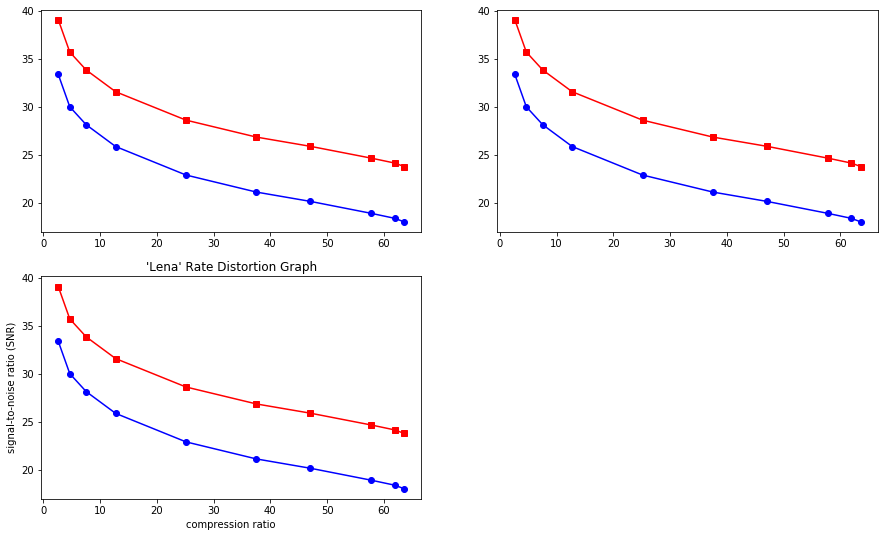

In [217]:
plt.figure(figsize=(15, 9))
plt.subplot(221)
plt.plot(sratios, snrs, 'bo-',pratios, psnrs, 'rs-')
plt.subplot(222)
plt.plot(sratios, snrs, 'bo-',pratios, psnrs, 'rs-')
plt.subplot(223)
plt.plot(sratios, snrs, 'bo-',pratios, psnrs, 'rs-')
plt.title("'Lena' Rate Distortion Graph")
plt.xlabel('compression ratio')
plt.ylabel('signal-to-noise ratio (SNR)')
plt.show()

In [176]:
MSE = mse(img, threshd[1])
print(MSE)

17.36274188152043


In [20]:
def qBlock(block, target=Q_MATRIX):
    quant = np.zeros(target.shape)
    #print(target)
    for x in range(block.shape[0]):
        for y in range(block.shape[1]):
            quant[x,y] = round(block[x,y]/target[x,y])*target[x,y]
    return quant

In [229]:
def getQuants(img):
    threshes = [0.01,0.02,0.03,0.05,0.1,0.15,0.2,0.3,0.4,0.5]
    quantd = []
    pquantd = []
    for i in range(0,10):
        thresh = threshes[i]
        pquantd.append(bdctTransform(img,8,thresh,True))
        quantd.append(bidctTransform(pquantd[i],8))
    return quantd,pquantd

In [220]:
snrs = []
sratios = []
print("control snr:",snr(img,img)," compression ratio:",findCompRatio(img, 8)[0], " bits after compression:", findCompRatio(img, 8)[1]*8)
for i in range(len(pquantd)):
    print(i,"= ",snr(img,quantd[i])," compression ratio:",findCompRatio(pquantd[i], 8)[0], " bits after compression:", findCompRatio(pquantd[i], 8)[1]*8)
    sratios.append(findCompRatio(pquantd[i], 8)[0])
    snrs.append(snr(quantd[i],img))

C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


control snr: inf  compression ratio: 1.3061224489795917  bits after compression: 200704
0 =  33.18675298321881  compression ratio: 2.6332104507146945  bits after compression: 99553
1 =  29.97343503399696  compression ratio: 4.66440098930624  bits after compression: 56201
2 =  28.1445408295405  compression ratio: 7.556106419162367  bits after compression: 34693
3 =  25.903232161806006  compression ratio: 12.747094578166788  bits after compression: 20565
4 =  22.96004337995944  compression ratio: 25.145707434052756  bits after compression: 10425
5 =  21.199457022935576  compression ratio: 37.5510671823521  bits after compression: 6981
6 =  20.241013869059046  compression ratio: 47.05510680308742  bits after compression: 5571
7 =  19.010487191117278  compression ratio: 57.791887125220455  bits after compression: 4536
8 =  18.50286083380157  compression ratio: 61.899409681227866  bits after compression: 4235
9 =  18.14205228945929  compression ratio: 63.565470417070806  bits after compress

In [221]:
psnrs = []
pratios = []
print("control psnr:",psnr(img,img)," compression ratio:",findCompRatio(img, 8)[0], " bits after compression:", findCompRatio(img, 8)[1])
for i in range(len(pquantd)):
    print(i,"= ",psnr(quantd[i],img)," compression ratio:",findCompRatio(pquantd[i], 8)[0], " bits after compression:", findCompRatio(pquantd[i], 8)[1])
    pratios.append(findCompRatio(pquantd[i], 8)[0])
    psnrs.append(psnr(quantd[i],img))

C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


control psnr: 0.0  compression ratio: 1.3061224489795917  bits after compression: 200704
0 =  38.873884533520574  compression ratio: 2.6332104507146945  bits after compression: 99553
1 =  35.66056658429872  compression ratio: 4.66440098930624  bits after compression: 56201
2 =  33.83167237984226  compression ratio: 7.556106419162367  bits after compression: 34693
3 =  31.590363712107767  compression ratio: 12.747094578166788  bits after compression: 20565
4 =  28.647174930261198  compression ratio: 25.145707434052756  bits after compression: 10425
5 =  26.886588573237333  compression ratio: 37.5510671823521  bits after compression: 6981
6 =  25.928145419360806  compression ratio: 47.05510680308742  bits after compression: 5571
7 =  24.69761874141904  compression ratio: 57.791887125220455  bits after compression: 4536
8 =  24.18999238410333  compression ratio: 61.899409681227866  bits after compression: 4235
9 =  23.829183839761047  compression ratio: 63.565470417070806  bits after comp

In [240]:
def getGraph(blockimg,pblockimg, ogimg, verbose):
    snrs = []
    sratios = []
    if verbose:
        print("control snr:",snr(ogimg,ogimg)," compression ratio:",findCompRatio(ogimg, 8)[0], " bits after compression:", findCompRatio(ogimg, 8)[1]*8)
    for i in range(len(pblockimg)):
        if verbose:
            print(i,"= ",snr(ogimg,blockimg[i])," compression ratio:",findCompRatio(pblockimg[i], 8)[0], " bits after compression:", findCompRatio(pblockimg[i], 8)[1]*8)
        sratios.append(findCompRatio(pblockimg[i], 8)[0])
        snrs.append(snr(blockimg[i],ogimg))
    psnrs = []
    pratios = []
    if verbose:
        print("control psnr:",psnr(ogimg,ogimg)," compression ratio:",findCompRatio(ogimg, 8)[0], " bits after compression:", findCompRatio(ogimg, 8)[1])
    for i in range(len(pblockimg)):
        if verbose:
            print(i,"= ",psnr(blockimg[i],ogimg)," compression ratio:",findCompRatio(pblockimg[i], 8)[0], " bits after compression:", findCompRatio(pblockimg[i], 8)[1])
        pratios.append(findCompRatio(pblockimg[i], 8)[0])
        psnrs.append(psnr(blockimg[i],ogimg))
    return sratios, snrs, pratios, psnrs

In [232]:
data_dir = r"C:\Users\callu\Pictures\Test\\"
#data_dir = r"./coursework-data/"
lena = Image.open(data_dir+"lena.png").convert("L")
lena = np.asarray(lena)
zeld = Image.open(data_dir+"zelda.png").convert("L")
zeld = np.asarray(zeld)
barb = Image.open(data_dir+"barbara.png").convert("L")
barb = np.asarray(barb)
imgs = [lena,zeld,barb]

In [ ]:
lthreshd, lpthreshd = getThreshes(lena)
zthreshd, zpthreshd = getThreshes(zeld)
bthreshd,bpthreshd = getThreshes(barb)
lquantd, lpquantd = getQuants(lena)
zquantd, zpquantd = getQuants(zeld)
bquantd,bpquantd = getQuants(barb)

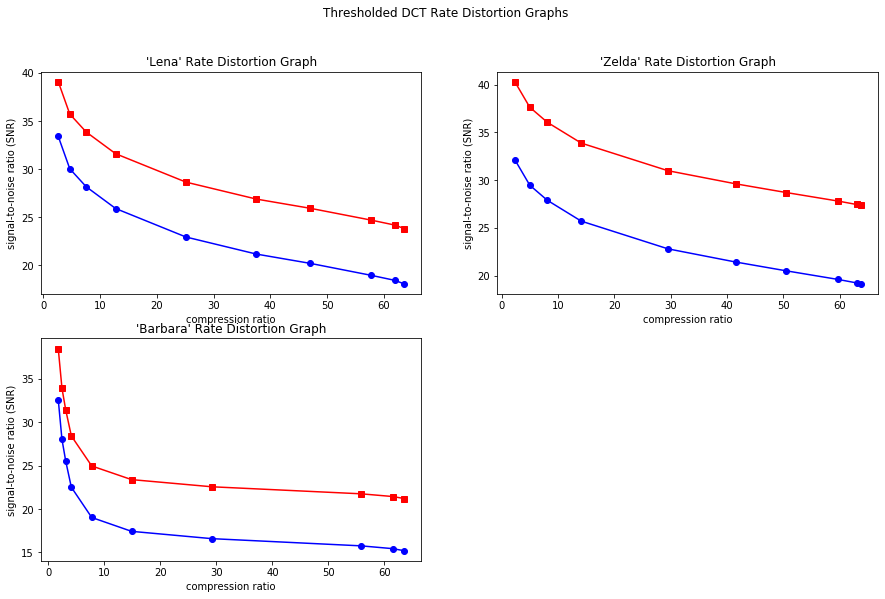

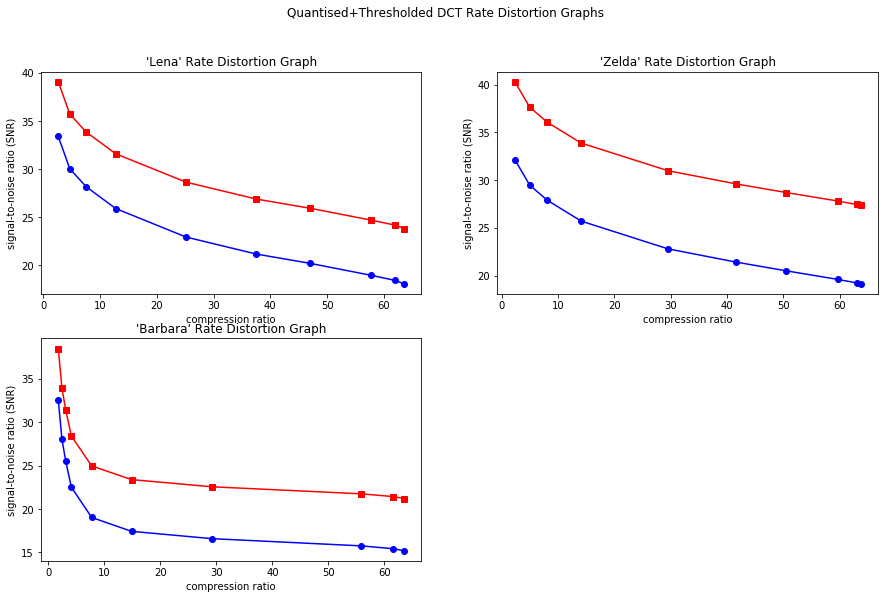

In [243]:
tl = getGraph(lthreshd, lpthreshd, lena, False)
ql = getGraph(lquantd,lpquantd, lena, False)
tz = getGraph(zthreshd, zpthreshd, zeld, False)
qz = getGraph(zquantd, zpquantd, zeld, False)
tb = getGraph(bthreshd, bpquantd, barb, False)
qb = getGraph(bquantd, bpquantd, barb, False)
ts = [tl,tz,tb]
qs = [ql,qz,qb]
titles = ["'Lena' Rate Distortion Graph","'Zelda' Rate Distortion Graph","'Barbara' Rate Distortion Graph"]
fig = plt.figure(figsize=(15, 9))
for i in range(3):
    plt.subplot(2,2,(i+1))
    plt.plot(ts[i][0], ts[i][1], 'bo-',ts[i][2], ts[i][3], 'rs-')
    plt.title(titles[i])
    plt.xlabel('compression ratio')
    plt.ylabel('signal-to-noise ratio (SNR)')
fig.suptitle('Thresholded DCT Rate Distortion Graphs')
plt.show()
fig = plt.figure(figsize=(15, 9))
for i in range(3):
    plt.subplot(2,2,(i+1))
    plt.plot(ts[i][0], ts[i][1], 'bo-',ts[i][2], ts[i][3], 'rs-')
    plt.title(titles[i])
    plt.xlabel('compression ratio')
    plt.ylabel('signal-to-noise ratio (SNR)')
fig.suptitle('Quantised+Thresholded DCT Rate Distortion Graphs')
plt.show()

In [244]:
for im in imgs:
    print(im.shape)

(512, 512)
(512, 512)
(512, 512)


In [24]:
MSE = mse(img, quantd[1])
print(MSE)

88.78975708788661


43.52046211247209
88.66603922456085
181.90360247098613
366.52472030024796


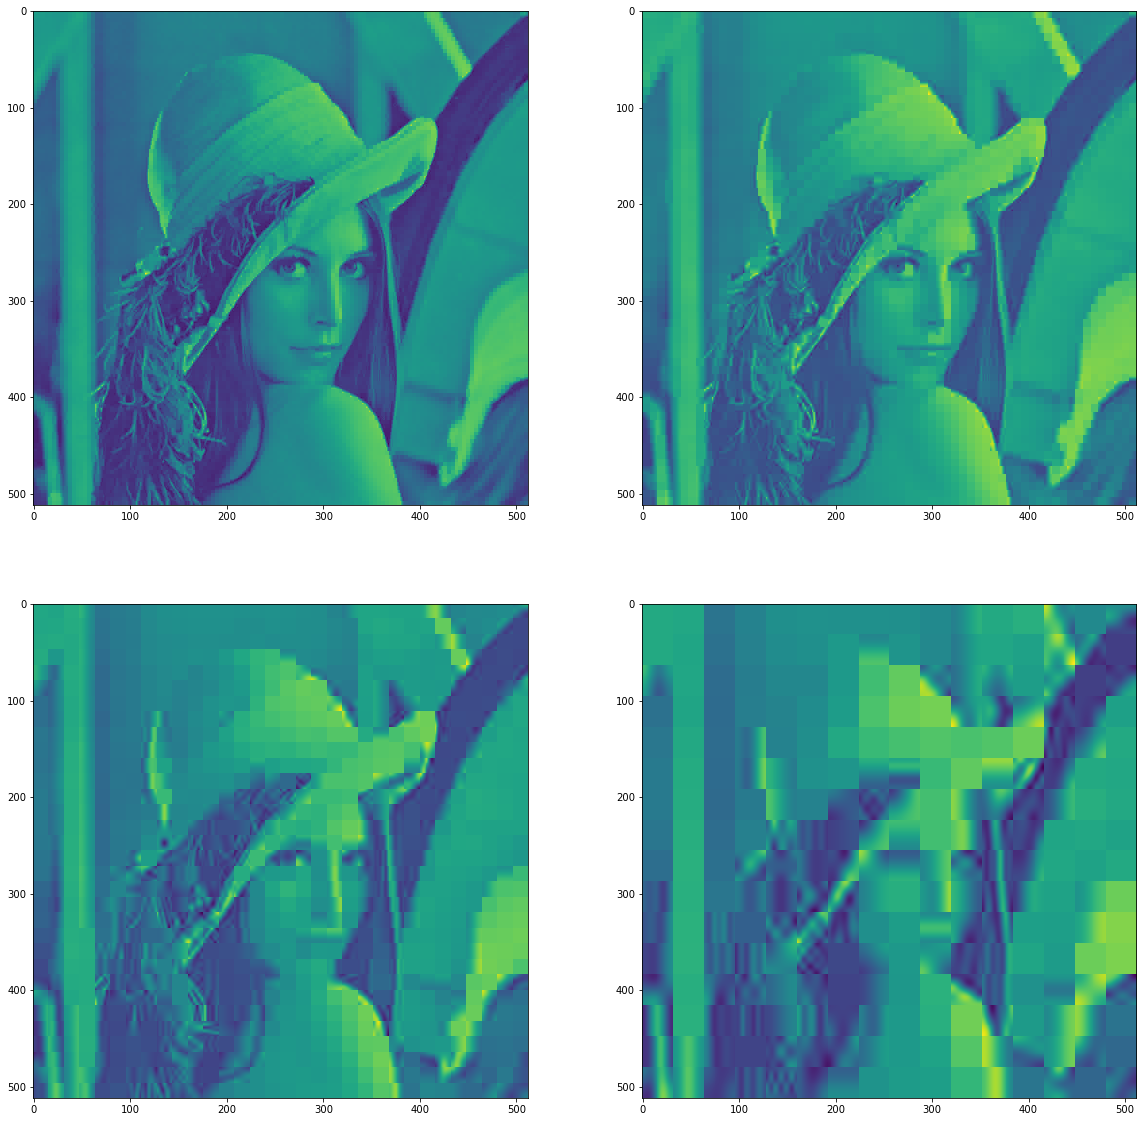

In [25]:
thresh = 0.1
four = bidctTransform(bdctTransform(img,4,thresh),4)
print(mse(img,four))
eight = bidctTransform(bdctTransform(img,8,thresh),8)
print(mse(img,eight))
sixteen = bidctTransform(bdctTransform(img,16,thresh),16)
print(mse(img,sixteen))
thirtytwo = bidctTransform(bdctTransform(img,32,thresh),32)
print(mse(img,thirtytwo))
fig = plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(four)
plt.subplot(2,2,2)
plt.imshow(eight)
plt.subplot(2,2,3)
plt.imshow(sixteen)
plt.subplot(2,2,4)
plt.imshow(thirtytwo)
plt.show()

In [26]:
def gaussian_kernel(sigma, norm=True):
    
    size = int(np.ceil(6 * sigma))  # kernel width is 6 x sigma
    
    if (size%2==0): # is the size even?
        size = size + 1 # make it odd 
        
    kernel = np.zeros((size,size), dtype='float') # kernel array
    
    h = size//2 # half size
    for y in range(0,size):
        for x in range(0,size):
            x2 = (x-h)*(x-h)
            y2 = (y-h)*(y-h)
            kernel[y, x] = np.exp(-(x2+y2)/(2*sigma*sigma))
    
    if norm:
        kernel /= np.sum(kernel) # normalise the kernel
    
    return kernel

In [27]:
def conv2d(im, kernel):

    h = kernel.shape[0]//2 # half the kernel size
    impad = np.pad(im,h,"edge")
    output = np.zeros(im.shape, dtype='float')
    for i in range(h,impad.shape[0]-h):
        for j in range(h,impad.shape[1]-h):

            output[i-h, j-h] = np.dot(impad[i-h:i+h+1,j-h:j+h+1].flatten(), kernel.flatten())
    return output

In [28]:
def reduce(im, kernel):
    
    # blur the input 
    im_blurred = conv2d(im.astype('float'), kernel)
    return im_blurred[::2,::2] # return subsampled version

def expand(im, kernel):

    # upsample by a factor of two by pixel duplication
    upsampled = np.zeros((2*im.shape[0], 2*im.shape[1]), dtype=im.dtype)
    for i in range(upsampled.shape[0]):
        for j in range(upsampled.shape[1]):
            upsampled[i, j] = im[i//2,j//2]

    # blur the upsampled image
    blurred = conv2d(upsampled.astype('float'), kernel)

    return blurred

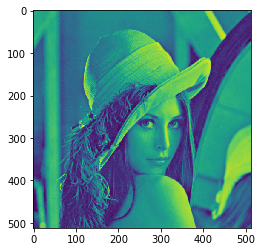

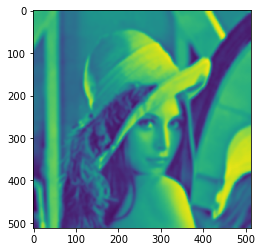

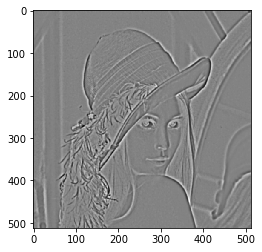

In [80]:
plt.imshow(img)
plt.show()

big = gaussian_kernel(3)
smol = gaussian_kernel(1)

blurred = conv2d(img,big)
padded_kernel = np.pad(smol, (big.shape[0]-smol.shape[0])//2, 'constant')
dog = big - padded_kernel

plt.imshow(blurred)
plt.show()

dogged = conv2d(img,dog)
plt.imshow(dogged, cmap="gray")
plt.show()

In [256]:
def build_pyramids(img, g):
    gauss_pyramid = [] # list to store the generated levels

    gauss_pyramid.append(img.astype('float')) # level 0 is the image

    n = int(np.log2(img.shape[0]))+1 # assume that the image size is a power of 2
    for i in range(1,n):

        
        level = reduce(gauss_pyramid[i-1], g)

        gauss_pyramid.append(level)

    lap_pyramid=[]
    for j in range(0,n-1):
        diff = gauss_pyramid[j]-expand(gauss_pyramid[j+1],g)
        #diff *= (255.0/diff.max())
        lap_pyramid.append(diff)

    return gauss_pyramid,lap_pyramid

def show_pyramid(pyramid):

        fig = plt.figure(figsize=(18,7))

        for i in range(len(pyramid)):

            plt.subplot(2,5,i+1)
            plt.imshow(pyramid[i], cmap='gray')
            plt.title('level '+str(i))
            plt.xticks([])
            plt.yticks([])

        plt.show()

1
2
3
4
5
6
7
8
9


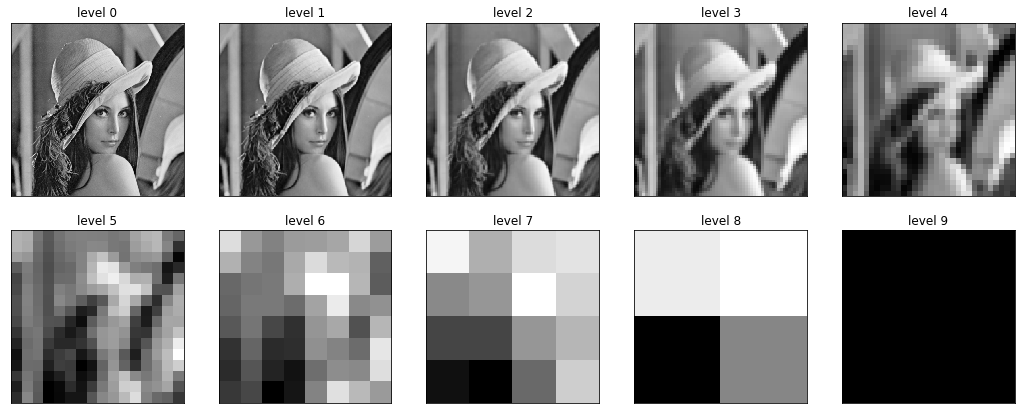

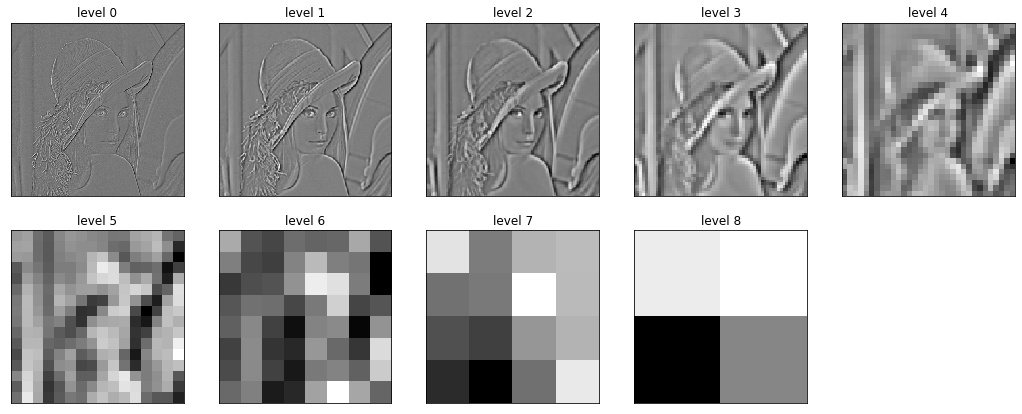

In [82]:
gauss,lapl = build_pyramids(img, smol)

show_pyramid(gauss)

show_pyramid(lapl)

In [83]:
def threshPyramid(pyramid):
    result = []
    for xj in range(len(pyramid)):
        temp_store = []
        pmax = 0
        for pix in pyramid[xj].ravel():
            if abs(pix)>pmax:
                pmax=abs(pix)
        for pix in pyramid[xj].ravel():
            if abs(pix)>(0.1*pmax):
                temp_store.append(pix)
            else:
                temp_store.append(0)
        new_store = np.asarray(temp_store)
        result.append(new_store.reshape((int(512//math.pow(2,(xj)))), int(512//math.pow(2,(xj)))))
    return result

In [91]:
thresh_lap = threshPyramid(lapl)
quant_lap = threshPyramid(lapl)

In [254]:
def quantisePyramid(pyramid):
    depth = len(pyramid)
    for i in range(0,depth):
        diff = pyramid[i].max() - pyramid[i].min()
        numdiff = float(diff)/(np.power(2,(i+1)))
        vals = []
        for n in range(np.power(2,(i+1))):
            vals.append(pyramid[i].min()+((n+1)*numdiff))
        for x in range(pyramid[i].shape[0]):
            for y in range(pyramid[i].shape[1]):
                closest = math.inf
                best = 0
                for v in vals:
                    if abs(pyramid[i][x,y]-v)<closest:
                        closest = abs(pyramid[i][x,y]-v)
                        best = v
                pyramid[i][x,y] = best
    return pyramid

max: 93.9597474454078
min: -82.41194420866759
diff 176.3716916540754
1
numdiff 88.1858458270377
2
numdiff 88.1858458270377
vals: [5.773901618370104, 93.9597474454078]
max: 72.0414003480061
min: -70.44841312576182
diff 142.48981347376792
1
numdiff 35.62245336844198
2
numdiff 35.62245336844198
3
numdiff 35.62245336844198
4
numdiff 35.62245336844198
vals: [-34.825959757319836, 0.7964936111221448, 36.418946979564126, 72.0414003480061]
max: 73.09468966715372
min: -69.71175329101213
diff 142.80644295816586
1
numdiff 17.850805369770733
2
numdiff 17.850805369770733
3
numdiff 17.850805369770733
4
numdiff 17.850805369770733
5
numdiff 17.850805369770733
6
numdiff 17.850805369770733
7
numdiff 17.850805369770733
8
numdiff 17.850805369770733
vals: [-51.8609479212414, -34.010142551470665, -16.159337181699932, 1.6914681880708002, 19.54227355784154, 37.393078927612265, 55.24388429738299, 73.09468966715373]
max: 55.76186859101128
min: -70.74832421779351
diff 126.51019280880479
1
numdiff 7.90688705055029

195
numdiff 0.04772241716228118
196
numdiff 0.04772241716228118
197
numdiff 0.04772241716228118
198
numdiff 0.04772241716228118
199
numdiff 0.04772241716228118
200
numdiff 0.04772241716228118
201
numdiff 0.04772241716228118
202
numdiff 0.04772241716228118
203
numdiff 0.04772241716228118
204
numdiff 0.04772241716228118
205
numdiff 0.04772241716228118
206
numdiff 0.04772241716228118
207
numdiff 0.04772241716228118
208
numdiff 0.04772241716228118
209
numdiff 0.04772241716228118
210
numdiff 0.04772241716228118
211
numdiff 0.04772241716228118
212
numdiff 0.04772241716228118
213
numdiff 0.04772241716228118
214
numdiff 0.04772241716228118
215
numdiff 0.04772241716228118
216
numdiff 0.04772241716228118
217
numdiff 0.04772241716228118
218
numdiff 0.04772241716228118
219
numdiff 0.04772241716228118
220
numdiff 0.04772241716228118
221
numdiff 0.04772241716228118
222
numdiff 0.04772241716228118
223
numdiff 0.04772241716228118
224
numdiff 0.04772241716228118
225
numdiff 0.04772241716228118
226
numd

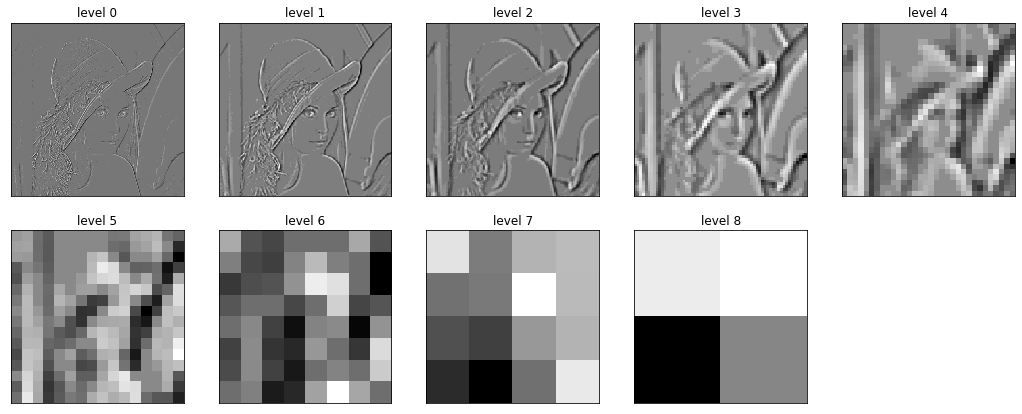

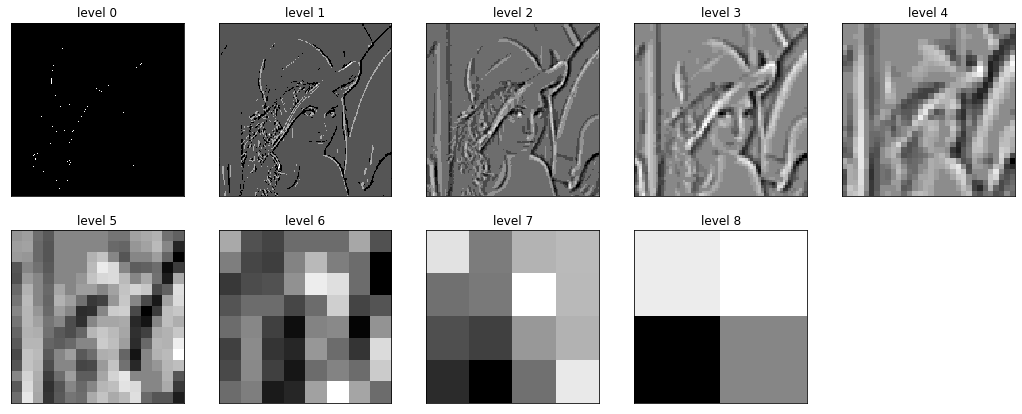

In [92]:
quantisePyramid(quant_lap)
show_pyramid(thresh_lap)
show_pyramid(quant_lap)

0
1
2
3
4
5
6
7
8
(512, 512)


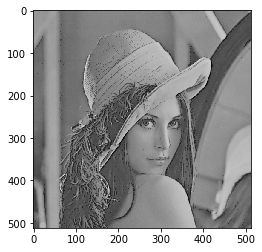

(256, 256)


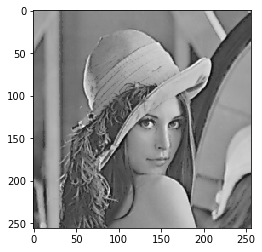

(128, 128)


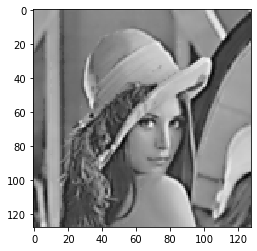

(64, 64)


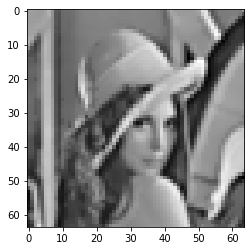

(32, 32)


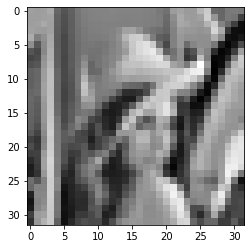

(16, 16)


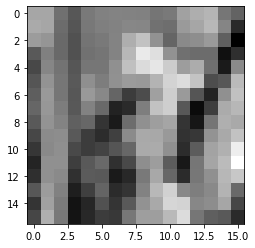

(8, 8)


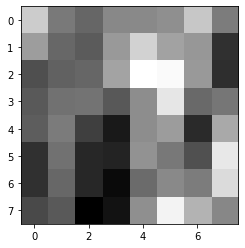

(4, 4)


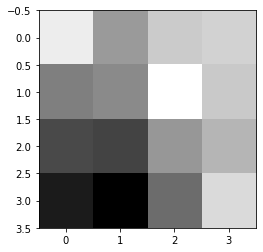

(2, 2)


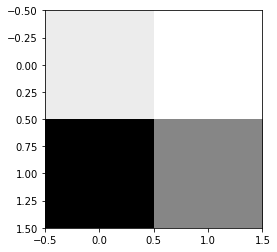

In [36]:
new_comb=[]
for level in range(len(quant_lap)):
    print(level)
    new_comb.append(gauss[level] + quant_lap[level])

for nc in new_comb:
    print(nc.shape)
    plt.imshow(nc,cmap='gray')
    plt.show()

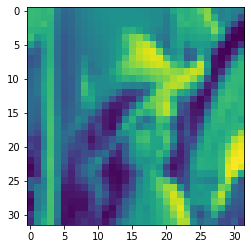

A (32, 32)
B (32, 32)


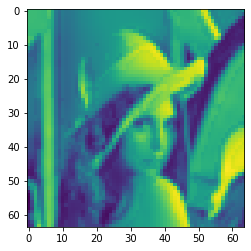

A (64, 64)
B (64, 64)


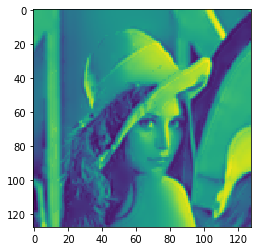

A (128, 128)
B (128, 128)


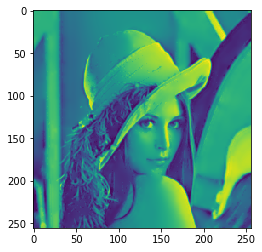

A (256, 256)
B (256, 256)


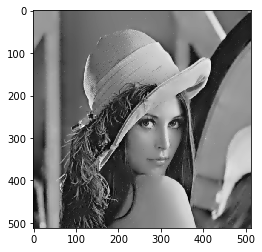

A (512, 512)
B (512, 512)


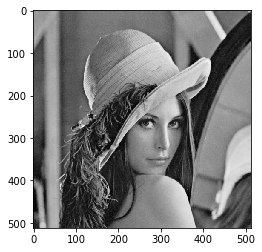

In [107]:
new_im = thresh_lap[4] + expand(gauss[5],smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[4].shape)
new_im = thresh_lap[3] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[3].shape)
new_im = thresh_lap[2] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[2].shape)
new_im = thresh_lap[1] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
print("A",new_im.shape)
print("B",gauss[1].shape)
new_im = thresh_lap[0] + expand(new_im,smol)
new_im *= (255.0/new_im.max())
plt.imshow(new_im, cmap="gray")
plt.show()
print("A",new_im.shape)
print("B",gauss[0].shape)
plt.imshow(img, cmap="gray")
plt.show()

In [263]:
def antiPyramid(level, gs, laps, filt=smol):
    new_im = gs[level]
    for i in range(level-1,-1,-1):
        new_im = laps[i] + expand(new_im,filt)
    return new_im

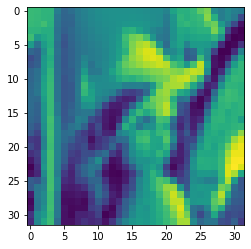

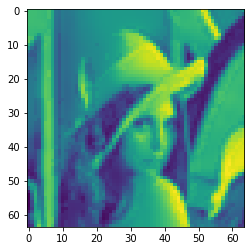

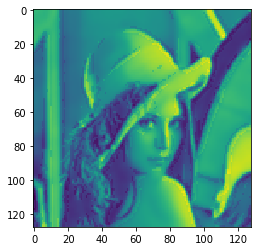

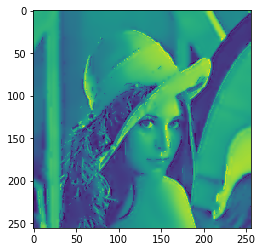

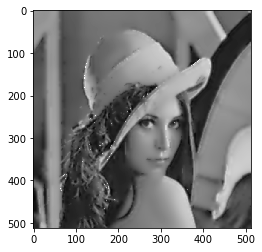

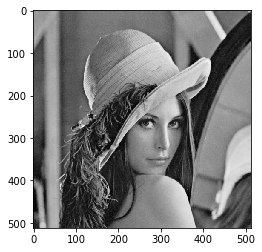

In [109]:
new_im = quant_lap[4] + expand(gauss[5],smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[3] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[2] + expand(gauss[3],smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[1] + expand(new_im,smol)
plt.imshow(new_im)
plt.show()
new_im = quant_lap[0] + expand(new_im,smol)
plt.imshow(new_im, cmap="gray")
plt.show()
plt.imshow(img, cmap="gray")
plt.show()

In [247]:
def lapCompRatio(level, imshape=512):
    gaussbits = np.square(imshape/np.power(2,level))*8
    lapbits = 0
    for i in range(level):
        laptemp = np.square(imshape/np.power(2,level))*(i+1)
        lapbits += laptemp
    return (imshape*imshape*8)/(gaussbits+lapbits), (gaussbits+lapbits)

In [251]:
print(lapCompRatio(3))

(36.57142857142857, 57344.0)


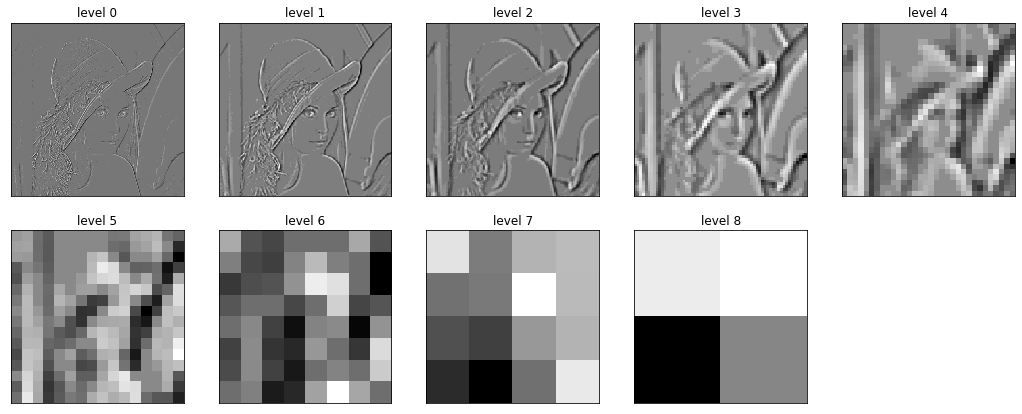

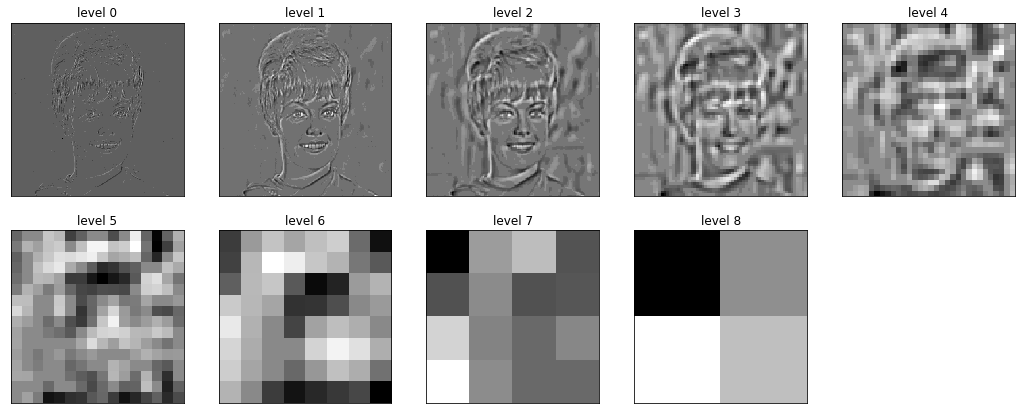

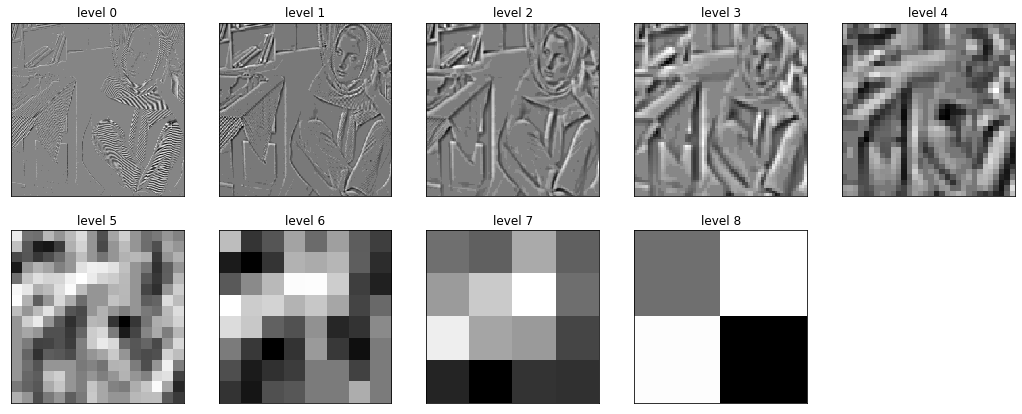

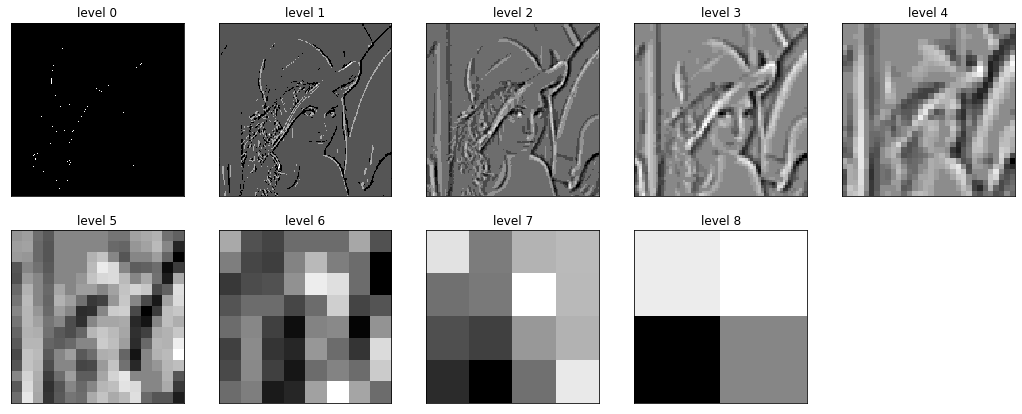

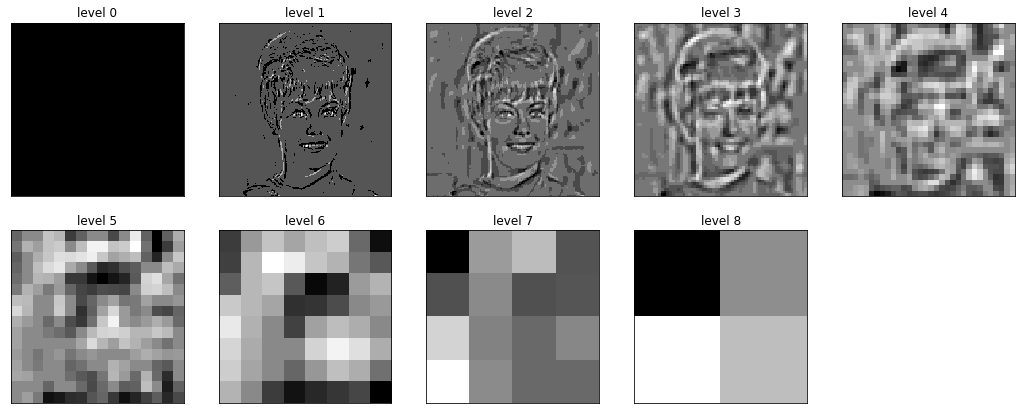

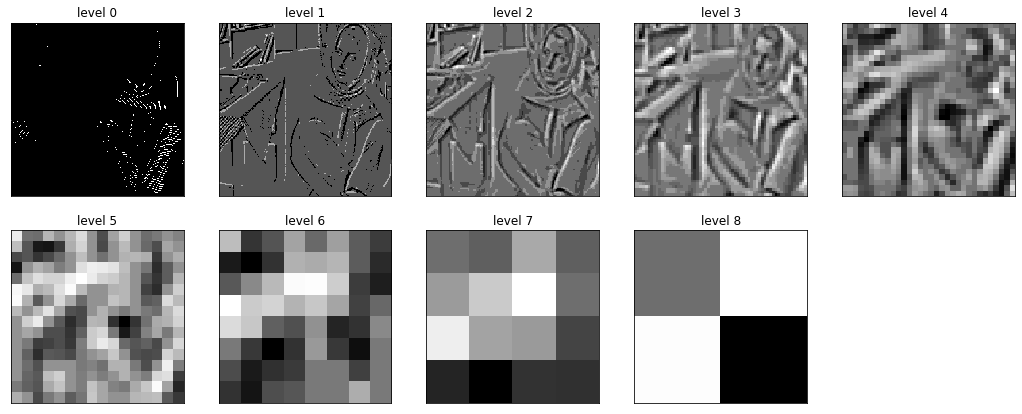

In [258]:
gausses = [None,None,None]
laps = [None,None,None]
tlaps = []
qlaps = []
for i in range(3):
    gausses[i], laps[i] = build_pyramids(imgs[i],smol)
for l in laps:
    tlaps.append(threshPyramid(l))
    qlaps.append(threshPyramid(l))
for q in qlaps:
    q = quantisePyramid(q)

for t in tlaps:
    show_pyramid(t)
for q in qlaps:
    show_pyramid(q)

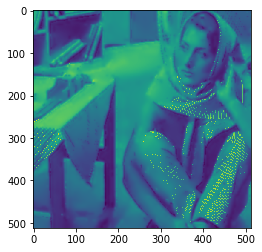

In [268]:
ltims = []
ztims = []
btims = []
lqims = []
zqims = []
bqims = []

plt.imshow(antiPyramid(5,gausses[2],qlaps[2]))
plt.show()

for i in range(0,7):
    ltims.append(antiPyramid(i,gausses[0],tlaps[0]))
    ztims.append(antiPyramid(i,gausses[1],tlaps[1]))
    btims.append(antiPyramid(i,gausses[2],tlaps[2]))
    lqims.append(antiPyramid(i,gausses[0],qlaps[0]))
    zqims.append(antiPyramid(i,gausses[1],qlaps[1]))
    bqims.append(antiPyramid(i,gausses[2],qlaps[2]))

In [288]:
def getLapGraph(newimg, ogimg, verbose):
    snrs = []
    sratios = []
    if verbose:
        print("control snr:",snr(ogimg,ogimg)," compression ratio:",lapCompRatio(0)[0], " bits after compression:", lapCompRatio(0)[1])
    for i in range(len(newimg)):
        if verbose:
            print(i,"= ",snr(ogimg,newimg[i])," compression ratio:",lapCompRatio(i)[0], " bits after compression:", lapCompRatio(i)[1])
        sratios.append(lapCompRatio(i)[0])
        snrs.append(snr(newimg[i],ogimg))
    psnrs = []
    pratios = []
    if verbose:
        print("control psnr:",psnr(ogimg,ogimg)," compression ratio:",lapCompRatio(0)[0], " bits after compression:", lapCompRatio(0)[1])
    for i in range(len(newimg)):
        if verbose:
            print(i,"= ",psnr(newimg[i],ogimg)," compression ratio:",lapCompRatio(i)[0], " bits after compression:", lapCompRatio(i)[1])
        pratios.append(lapCompRatio(i)[0])
        psnrs.append(psnr(newimg[i],ogimg))
    return sratios, snrs, pratios, psnrs

In [300]:
tl = getLapGraph(ltims, lena, True)
ql = getLapGraph(lqims, lena, False)
tz = getLapGraph(ztims, zeld, False)
qz = getLapGraph(zqims, zeld, False)
tb = getLapGraph(btims, barb, False)
qb = getLapGraph(bqims, barb, False)

C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\callu\Miniconda3\envs\MLtest\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


control snr: inf  compression ratio: 1.0  bits after compression: 2097152.0
0 =  inf  compression ratio: 1.0  bits after compression: 2097152.0
1 =  32.080656121477176  compression ratio: 3.5555555555555554  bits after compression: 589824.0
2 =  30.129300869187198  compression ratio: 11.636363636363637  bits after compression: 180224.0
3 =  28.834083097983108  compression ratio: 36.57142857142857  bits after compression: 57344.0
4 =  28.071992135805196  compression ratio: 113.77777777777777  bits after compression: 18432.0
5 =  27.606712678905318  compression ratio: 356.17391304347825  bits after compression: 5888.0
6 =  27.519985663627452  compression ratio: 1129.9310344827586  bits after compression: 1856.0
control psnr: 0.0  compression ratio: 1.0  bits after compression: 2097152.0
0 =  0.0  compression ratio: 1.0  bits after compression: 2097152.0
1 =  37.76778767177894  compression ratio: 3.5555555555555554  bits after compression: 589824.0
2 =  35.816432419488955  compression rat

33.20711721392921


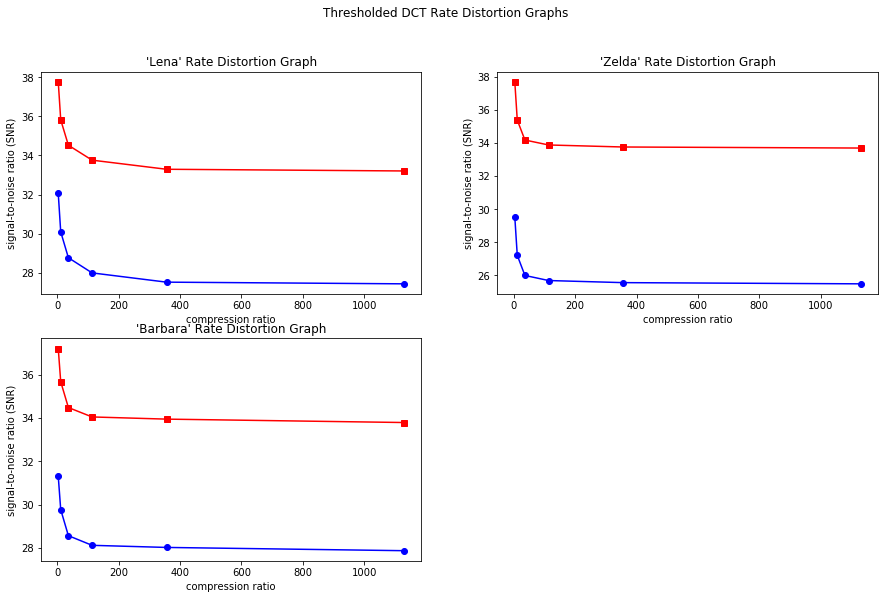

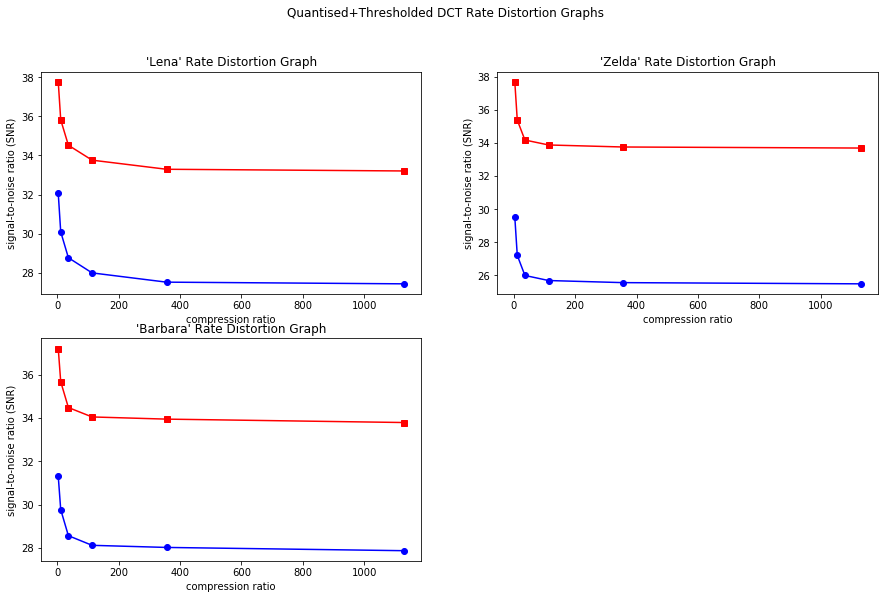

In [302]:
ts = [tl,tz,tb]
print(ts[0][3][6])
qs = [ql,qz,qb]
titles = ["'Lena' Rate Distortion Graph","'Zelda' Rate Distortion Graph","'Barbara' Rate Distortion Graph"]
fig = plt.figure(figsize=(15, 9))
for i in range(3):
    plt.subplot(2,2,(i+1))
    plt.plot(ts[i][0][1:], ts[i][1][1:], 'bo-',ts[i][2][1:], ts[i][3][1:], 'rs-')
    plt.title(titles[i])
    plt.xlabel('compression ratio')
    plt.ylabel('signal-to-noise ratio (SNR)')
fig.suptitle('Thresholded DCT Rate Distortion Graphs')
plt.show()
fig = plt.figure(figsize=(15, 9))
for i in range(3):
    plt.subplot(2,2,(i+1))
    plt.plot(ts[i][0][1:], ts[i][1][1:], 'bo-',ts[i][2][1:], ts[i][3][1:], 'rs-')
    plt.title(titles[i])
    plt.xlabel('compression ratio')
    plt.ylabel('signal-to-noise ratio (SNR)')
fig.suptitle('Quantised+Thresholded DCT Rate Distortion Graphs')
plt.show()